In [2]:
from astroquery.esa.jwst import Jwst
import numpy as np
from datetime import datetime

from tqdm.notebook import tqdm
tqdm.pandas()

import pandas as pd
from astropy.io import fits
import astropy.time as at
from astroquery.jplhorizons import Horizons
import re
import os
import sys
import logging
import glob
import shapely.wkt
from shapely.geometry import Polygon, Point
from reproject import reproject_interp
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import math as mt
from astropy.time import Time
from astroquery.imcce import Skybot
import astropy.units as u
from astropy.visualization import ZScaleInterval, ImageNormalize,LinearStretch, SqrtStretch, simple_norm
from astropy.nddata import Cutout2D
from PIL import Image
from matplotlib import cm
import numpy as np
from sbident import SBIdent
import time

from scipy import ndimage
from skimage.filters import threshold_otsu
import matplotlib.colors as mcolors

import warnings
warnings.filterwarnings('ignore')

In [3]:
#Cosmos Account Credentials
Jwst.login(user='nmartind', password='Mr.Fantastic1999')

INFO: OK [astroquery.utils.tap.core]


In [4]:
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [5]:
def MJDconversion(modifiedJulianDate):
    #Convert Modified Julian Date to YYYMMDD[H:M:S] format
    date = at.Time(modifiedJulianDate, format = 'mjd')
    date.format = 'iso' # 'YYYY-MM-DD HH:MM:SS'
    #To get the string format just call str(date)
    return(date)

In [6]:
def isLocatedInImage(targetRA, targetDEC, imagePOLYGON):
    #Check if the RA and DEC coordinate exist within the image bound polygon (returns boolean)
    return(imagePOLYGON.contains(Point(targetRA, targetDEC)))

In [7]:
def formatPolygon(string):
    #Format the saved polygon from the archive to the one suitable with shapely
    values_ = string.split(' ')
    string_ = string.replace('Polygon ','POLYGON((')
    
    # add in the commas at every other space
    string_ = re.sub(r'(\s\S*?)\s', r'\1, ',string_)
    
    #Add in the final chracter so that it matches the first (ie forms a closed polygon)
    string_ = string_ + f', {values_[1]} {values_[2]}))'
    string_ = string_.replace('POLYGON(', 'POLYGON (')
    return(string_)

In [8]:
def replace_values(val):
    if val == 0:
        return 'No'
    elif val == 1:
        return 'Yes'
    return val

In [9]:
def query4info(propRange, instrumentName):
    propList = [i for i in range(propRange[0], propRange[1])]
    proposals = ', '.join([f"'{p}'" for p in propList])
    
    #determine what level 2 i2d image composites for a given level 3 image
    readouts =  ['proposal_id','observationid','instrument_name','energy_bandpassname','target_moving','position_bounds_spoly','time_bounds_lower','time_bounds_upper']
    query_filters = [f'jwst.archive.calibrationlevel = 2', f"jwst.archive.dataproducttype = 'image'", f"jwst.archive.proposal_id IN ({proposals})", f"jwst.archive.instrument_name = '{instrumentName}'"]
    
    readout_string = ','.join(readouts)
    filter_string = ' AND '.join(query_filters)
    query_string = f"SELECT {readout_string} FROM jwst.archive WHERE ({filter_string})"
    
    #Pull data formatted by the display amount, volume and filter 
    job = Jwst.launch_job(query_string, async_job=True)
    result = job.get_results()
    pandas = result.to_pandas()
    
    return(pandas)

In [10]:
def pullWCS(imagePath):
    #recover data from a fits file
    if os.path.exists(imagePath):
        with fits.open(imagePath) as hdul:        
            data = hdul[1].data
            header = hdul[1].header
            wcs_info = WCS(header)
                       
    else:
        wcs_info = None
        data = None
   
    return(data, wcs_info)

In [11]:
def determinePhaseAngle(asteroidName, expStart, expEnd):

    asteroidData = Horizons(id=asteroidName, location='Geocentric@JWST', epochs={'start': str(expStart), 'stop' : str(expEnd), 'step' : str(1) + 'm'}) 
    asteroidEphem = asteroidData.ephemerides()
    asteroidPandas = asteroidEphem.to_pandas()
    
    alpha = str(asteroidPandas['alpha'].iloc[len(asteroidPandas) // 2])
    
    return(alpha)

In [12]:
def generateFolder(folderName):
    if os.path.exists(folderName):
        pass
    else:
        Warning('Save location did not exist. Using the current working directory...')
        cwd = os.getcwd()
        save_loc = f'{folderName}'
        os.mkdir(folderName)
        #print(f'Generating New Save Location {cwd}/{folderName}')

In [13]:
def produceOriginalImage(imageData, WCS, obsID, filePath):
    if not os.path.exists(f'{filePath}/Original_{obsID}.png'):
        fig = plt.figure(figsize = (20,20))
        ax  = plt.subplot(1,1,1, projection = WCS)

        ax.set_xlabel('RA')
        ax.set_ylabel('DEC')

        ax.title.set_text(f'{obsID} i2d Image')

        #interval = ZScaleInterval()
        #vmin, vmax = interval.get_limits(imageData)
        #norm = ImageNormalize(vmin=vmin, vmax=vmax)
        norm = simple_norm(imageData, 'sqrt')

        cax = ax.imshow(imageData, cmap='viridis',norm=norm)

        plt.savefig(f'{filePath}/Original_{obsID}.png') 
        plt.close()
        #print(f'{filePath}/Original_{obsID}.png')
    #else:
    #    continue
    #    print('previously generated original')

In [14]:
def produceOverlayImage(imageData, WCS, obsID, asteroidList, Xlist, Ylist, filePath):
    if not os.path.exists(f'{filePath}/Overlay_{obsID}.png'):
        
        
        fig = plt.figure(figsize = (20+10*(len(asteroidList)-1),10))
        ax1 = plt.subplot(1,len(asteroidList)+1,1, projection = WCS)

        ax1.set_xlabel('RA')
        ax1.set_ylabel('DEC')

        ax1.title.set_text(f'{obsID} i2d Image')

        #asinh_norm = AsinhNorm(vmin=np.min(imageData), vmax=np.max(imageData), a=2)
        norm = simple_norm(imageData, 'sqrt')

        cax1 = ax1.imshow(imageData, cmap='viridis',norm=norm, aspect='auto', zorder = 1)

        colors = ['orangered','maroon','firebrick','goldenrod','tomato','chocolate', 'tab:red', 'tab:orange','yellow','red','orange']

        for asteroid in asteroidList:
            indx = asteroidList.index(asteroid)

            ax_ = plt.subplot(1, len(asteroidList)+1, indx+2, projection = WCS)
            ax_.set_xlabel('RA')
            ax_.set_ylabel('DEC')
            ax_.title.set_text(f'{obsID} Asteroid {asteroid}')

            # Apply custom normalization
            #exp_norm = ExpNorm(vmin=np.min(imageData), vmax=np.max(imageData), k=0.95)

            cax_ = ax_.imshow(imageData, cmap='viridis',norm=norm, aspect='auto', zorder = 1)

            X = Xlist[indx]
            Y = Ylist[indx]

            extraPixels = 10        

            if len(X) >> 1:
                P1 = [X[0],  Y[0]]
                P2 = [X[-1], Y[-1]]

            else:
                P1 = [X[0],Y[0]]
                P2 = [X[0],Y[0]]

            #Define the default bounds    
            lowerx = round(min(P1[0],P2[0])) - extraPixels
            upperx = round(max(P1[0],P2[0])) + extraPixels
            lowery = round(min(P1[1],P2[1])) - extraPixels
            uppery = round(max(P1[1],P2[1])) + extraPixels

            ax1.plot([lowerx, upperx, upperx, lowerx, lowerx],[lowery, lowery, uppery, uppery, lowery], alpha = 0.6,  c=colors[indx], linewidth = 2, zorder = 2, label = asteroid)

            ax_.scatter(X, Y, s=15, alpha = 0.8, c=colors[indx], zorder = 2, label = asteroid)

            ax_.set(xlim=(lowerx, upperx), ylim=(lowery, uppery))       

        #plt.colorbar(cax, orientation='vertical')
        ax1.legend()
        #plt.tight_layout()
        plt.savefig(f'{filePath}/Overlay_{obsID}.png') 
        plt.close()


In [15]:
def highContrastImage(imageData, WCS, asteroidName, X,Y, path, observation):
    #if not os.path.exists(f'{path}/HighContrastZoom_{observation}_{asteroidName}.png'):
    
    #Generate cutout
    rows, cols = imageData.shape

    extraPixels = 15

    # Calculate the crop boundaries, with bounds checking
    col_start = max(mt.floor(min(X)-extraPixels), 0)  # Ensure not below 0
    col_end =   min(mt.floor(max(X)+extraPixels), cols - 1)  # Ensure not above max columns
    row_start = max(mt.floor(min(Y)-extraPixels), 0)  # Ensure not below 0
    row_end =   min(mt.floor(max(Y)+extraPixels), rows - 1)  # Ensure not above max rows

    yBound = [col_start, col_end]
    xBound = [row_start, row_end]

    
    fig = plt.figure(figsize = (20,20))

    plt.title(f"High Contrast Zoom of Asteroid {asteroidName}")
    plt.xlabel('Pixel Columns')
    plt.ylabel('Pixel Rows')

    asinh_norm = AsinhNorm(a=0.2)#ADD CLIPPING

    cax = plt.imshow(imageData[xBound[0]:xBound[1],yBound[0]:yBound[1]],cmap='viridis', norm= asinh_norm)

    plt.colorbar(cax)
    plt.gca().invert_yaxis()
    plt.savefig(f'{path}/HighContrastZoom_{observation}_{asteroidName}.png') 
    plt.close() 
    

    return(imageData[xBound[0]:xBound[1],yBound[0]:yBound[1]])

    #else:
    #    return(False)

In [16]:
# Define custom asinh normalization function
class AsinhNorm(mcolors.Normalize):
    def __init__(self, vmin=None, vmax=None, a=0.1, clip=False):
        self.a = a  # Scaling parameter
        super().__init__(vmin=vmin, vmax=vmax, clip=clip)

    def __call__(self, value, clip=None):
        value = np.ma.masked_array(value, mask=np.isnan(value))
        if self.vmin is None:
            self.vmin = np.min(value)
        if self.vmax is None:
            self.vmax = np.max(value)
        if clip is None:
            clip = self.clip
        normalized = (value - self.vmin) / (self.vmax - self.vmin)
        normalized_asinh = np.arcsinh(self.a * normalized) / np.arcsinh(self.a)

        # Clip the values if needed
        if clip:
            normalized_asinh = np.clip(normalized_asinh, 0, 1)

        return normalized_asinh

In [17]:
class ExpNorm(mcolors.Normalize):
    def __init__(self, vmin=None, vmax=None, k=5, clip=False):
        self.k = k  # Scaling parameter for exponential stretching
        super().__init__(vmin=vmin, vmax=vmax, clip=clip)

    def __call__(self, value, clip=None):
        value = np.ma.masked_array(value, mask=np.isnan(value))
        if self.vmin is None:
            self.vmin = np.min(value)
        if self.vmax is None:
            self.vmax = np.max(value)
        normalized = (value - self.vmin) / (self.vmax - self.vmin)
        return np.exp(self.k * normalized) - 1

In [18]:
def generateSNRimage(imageData, path, observation, asteroidName):
    #if not os.path.exists(f'{path}/SNR_{observation}_{asteroidName}.png'):
    # Step 1: Mask out the zero values and nan values
    #valid_pixels = image[~np.isnan(image)].flatten()
    non_zero_image = np.ma.masked_equal(imageData, 0)

    masked_image = np.ma.masked_where(np.isnan(non_zero_image), non_zero_image)

    # Step 2: Flatten the image, excluding the masked zero values
    valid_pixels = masked_image.compressed()  # This gives a 1D array of non-zero values

    # Step 3: Apply Otsu's threshold to separate the source from the background
    threshold_value = threshold_otsu(valid_pixels)

    # Step 4: Separate signal (pixels above threshold) and background (below threshold)
    signal_pixels = valid_pixels[valid_pixels > threshold_value]
    background_pixels = valid_pixels[valid_pixels <= threshold_value]

    # Step 5: Calculate mean and standard deviation of signal and background
    mean_signal = np.mean(signal_pixels)
    mean_background = np.mean(background_pixels)

    snr = mean_signal / mean_background

    #print('background',mean_background)
    #print('signal',mean_signal)

    # Plot the image and mask
    plt.figure(figsize=(30, 10))

    plt.subplot(1, 3, 1)
    plt.title('Original Image with Source')
    cax1 = plt.imshow(masked_image, cmap='gray', zorder = 2)
    plt.scatter([0],[0], c = 'white', label = asteroidName, zorder = 1)
    plt.legend()
    plt.colorbar(cax1)
    plt.gca().invert_yaxis()

    plt.subplot(1, 3, 2)
    plt.title(f'Mask using Otsu Threshold = {threshold_value:.2f},  S/N = {snr:.2f}')
    cax2 = plt.imshow(masked_image > threshold_value, cmap='gray')
    plt.colorbar(cax2)
    plt.gca().invert_yaxis()


    # Step 1: Flatten the 2D image into a 1D array
    flattened_data = imageData.ravel()  # Flatten the 2D array to 1D
    #remove any nans from the 1D array        
    cleaned_data = [x for x in flattened_data if x!= 0 and not np.isnan(x)]                                                                  

    # Step 2: Create a 1D histogram of pixel values
    # Binning pixel values into 50 bins (you can adjust the number of bins)
    hist, bin_edges = np.histogram(cleaned_data, bins=50)

    # Step 3: Plot the 1D histogram
    plt.subplot(1, 3, 3)
    plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), edgecolor='black', align='edge')
    plt.title('1D Histogram of Pixel Values')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.grid(True)

    # Step 4: Find the most common pixel value (the bin with the maximum count)
    max_bin_index = max(hist)  # Index of the bin with the highest frequency
    #most_common_pixel_value = bin_edges[max_bin_index]  # The corresponding pixel value

    plt.axvline(x = mean_background, ymax=(max_bin_index / plt.ylim()[1])+20, color = 'black', linestyle = 'dashed', label = f'Average Background = {mean_background:.2f}')
    plt.axvline(x = threshold_value, ymax=(max_bin_index / plt.ylim()[1])+20, color = 'green', linestyle = 'dashed', label = f'Otsu Threshold = {threshold_value:.2f}')
    plt.axvline(x = mean_signal,     ymax=(max_bin_index / plt.ylim()[1])+20, color = 'red',   linestyle = 'dashed', label = f'Average Signal = {mean_signal:.2f}')

    plt.legend(loc = 'upper right')
    #print(f'The most common pixel value is approximately: {most_common_pixel_value}')

    plt.savefig(f'{path}/SNR_{observation}_{asteroidName}.png') 
    plt.close()

    return(f'{snr:.3f}')

In [19]:
def jplHorizonsSearch(targetID, startTime, stopTime, polyString):
    #Search the JPL Horizons data for a specific target to get orbital values. This method is more accurate then the cone search and provides a double check for asteroids (named from the cone search) existing in the image
    
    #generate polygon as a shapely function
    poly = shapely.wkt.loads(polyString)
    
    probeMinutes = 1
        
    #Grab the data every 600min since we only care about it if belongs in the image not the shape at this point, always returns first point even for short exposures
    obj = Horizons(id=targetID, location='Geocentric@JWST', epochs={'start': str(startTime), 'stop' : str(stopTime), 'step' : str(probeMinutes) + 'm'}) 

    #get Ephemerides data
    ephemJPL = obj.ephemerides()
    ephemJPL = ephemJPL.to_pandas()
    
    asteroidRA =   ephemJPL['RA']
    asteroidDEC =  ephemJPL['DEC']
    
    contained = False
    
    for positionIndx in range(len(asteroidRA)):
        isContained = isLocatedInImage(asteroidRA[positionIndx], asteroidDEC[positionIndx], poly)
        if isContained:           
            contained = True
                
    return(asteroidRA, asteroidDEC, contained)

In [20]:
def nonZeroCheck(imageData, WCS, X,Y, RA, DEC, path, observation):    
    probeValues = []

    for x,y in zip(X,Y):
        try:
            #print(f"Value: {imageData[mt.floor(y),mt.floor(x)]}")
            probeValues.append(imageData[mt.floor(y),mt.floor(x)])
        except:
            if len(probeValues) == 0: 
                for x,y in reversed(list(zip(X,Y))):
                    try:
                        #print(f"Value: {imageData[mt.floor(y),mt.floor(x)]}")
                        probeValues.append(imageData[mt.floor(y),mt.floor(x)])
                    except:
                        pass
        
    nonZeroBool = np.sum(~np.isnan(np.array(probeValues)) & (np.array(probeValues) != 0)) > (len(probeValues) // 2)
    
    return(nonZeroBool)

In [34]:
def asteroidsearch(asteroidName, row, folderName, override):
    
    proposal = row['proposal_id']
    observation = row['observationid']
    polygonString = row['position_bounds_spoly']
    expStartMJD = row['time_bounds_lower']
    expEndMJD = row['time_bounds_upper']
    
    outputFolder = f"{folderName}/{proposal}"
    generateFolder(outputFolder)
    
    try:
        #reformat the image polygon
        polyStringFmt =  str(formatPolygon(str(polygonString)))
    except:
        return([False,False,False,False])
        
    
    #convertTime format
    expStart = (MJDconversion(expStartMJD))
    expEnd   = (MJDconversion(expEndMJD))
    
    raList, decList, containedCheck = jplHorizonsSearch(asteroidName, expStart, expEnd, polyStringFmt)

    if containedCheck or override:
        #pull the WCS and image data for the observation
        dataPath = f'/data/user/jwst_jw01/jw0{proposal}/{observation}_i2d.fits.gz'
        imageData, WCS = pullWCS(dataPath)

        if WCS is None:
            print(f"ERROR: Image Data from {dataPath} Not Found")
        else:
            #convert RA and DEC to pixel locations
            asteroidPixelX, asteroidPixelY = WCS.all_world2pix(raList, decList, 0)
            
            nonZero = True

            if not override:
                #perform the non zero check to ensure that the asteroid travels across the sensor and not the dead area
                nonZero = nonZeroCheck(imageData, WCS, asteroidPixelX, asteroidPixelY, raList, decList, outputFolder, observation)

            if nonZero or override:
                produceOverlayImage(imageData, WCS, observation, asteroidName, asteroidPixelX, asteroidPixelY, outputFolder)

                croppedImg = highContrastImage(imageData, WCS, asteroidName, asteroidPixelX, asteroidPixelY, outputFolder, observation)

                if not isinstance(croppedImg, bool):
                    snr = generateSNRimage(croppedImg, outputFolder, observation, asteroidName)
                    phaseAngle = determinePhaseAngle(containedAsteroidNames[indx], expStart, expEnd)
                    
                    new_col1 = expStart
                    new_col2 = expEnd
                    new_col3 = snr
                    new_col4 = phaseAngle
                    
                    return ([new_col1, new_col2, new_col3, new_col4])
                    
                
    new_col1 = False
    new_col2 = False
    new_col3 = False
    new_col4 = False
    
    return([new_col1, new_col2, new_col3, new_col4])

In [35]:
def main(asteroidName, propRange, instrument, override = False):
    
    folderName = f"LVL2_{asteroidName}_Check"
    generateFolder(folderName)
    
    with HiddenPrints():
        lvl2DF = query4info(propRange, instrument)

    print(f"From proposal range {propRange} found {len(lvl2DF)} Observations to check for {asteroidName}")
        
    titles = ['Proposal', 'Observation', 'Filter', 'Moving', 'Polygon', 'Exp Start', 'Exp End', 'Asteroids', 'S/N', 'Phase Angle']
    
    newAsteroidCSV = pd.DataFrame(columns=titles)
    
    for index, row in tqdm(lvl2DF.iterrows()):
        newVals = asteroidsearch(asteroidName, row, folderName, override)
        
        if newVals[0] != False:
            newRow = [row['proposal_id'], row['observationid'], row['energy_bandpassname'], row['target_moving'], newVals[0], newVals[1], asteroidName, newVals[2], newVals[3]]
        
            newAsteroidCSV = newAsteroidCSV.append(pd.Series(newRow, index=newAsteroidCSV.columns), ignore_index=True)
        

    newAsteroidCSV.reset_index(inplace=True, drop=True)
    asteroidCSV['Moving'] = asteroidCSV['Moving'].apply(replace_values)

    csvName = f'{folderName}/{asteroid}_LVL2_Observations_Prop{propRange[0]}_{propRange[1]}.csv'
    asteroidCSV.to_csv(csvName, index=False)

From proposal range [1720, 1730] found 1260 Observations to check for 2007 XR66


0it [00:00, ?it/s]

TypeError: object of type 'numpy.float64' has no len()

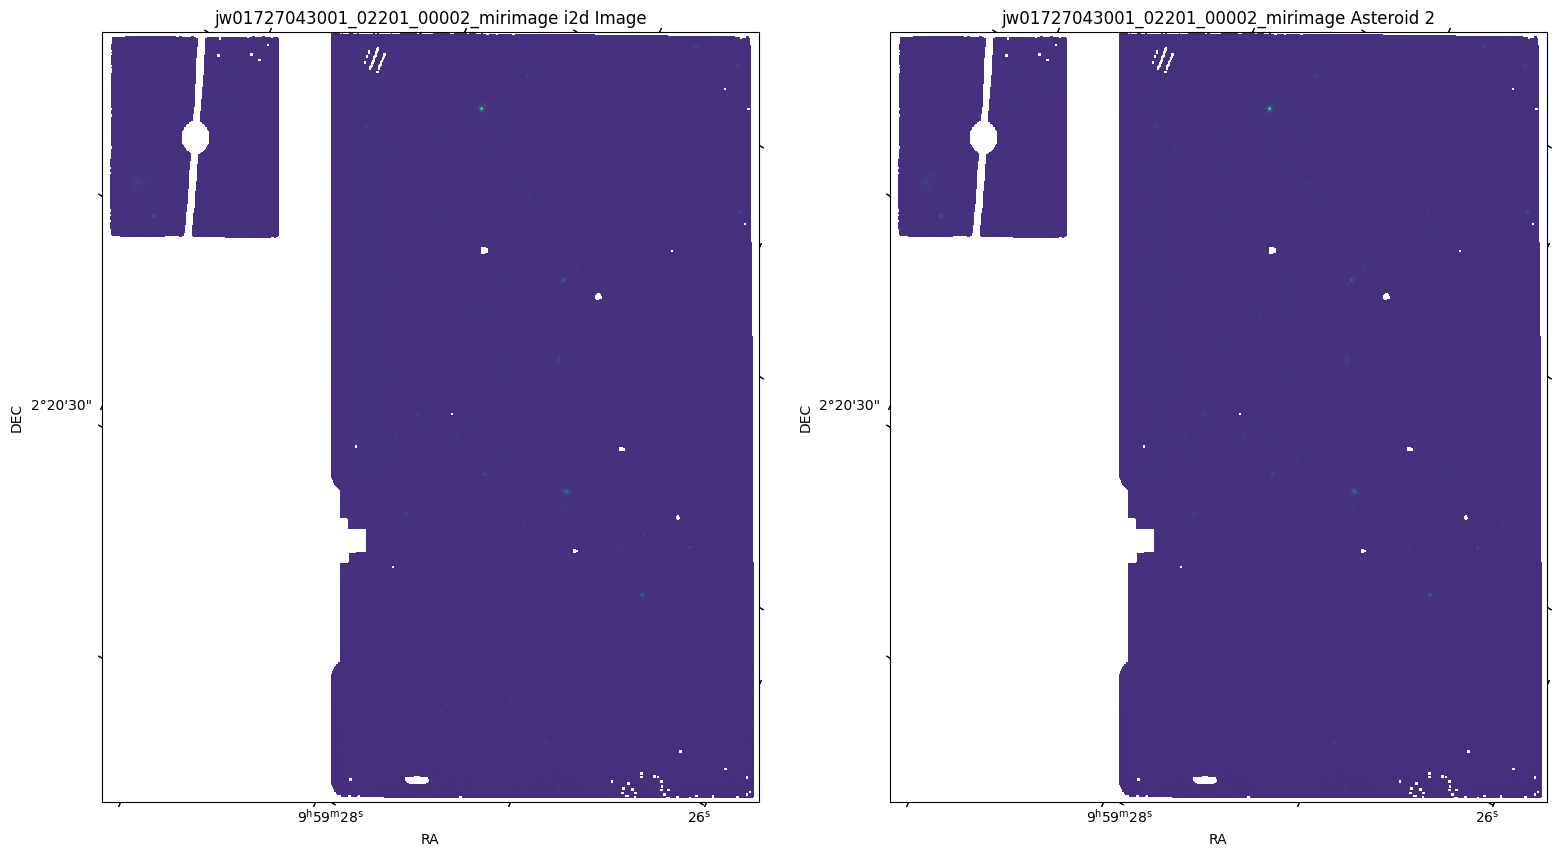

In [37]:
%%time
main("2007 XR66", [1720,1730], 'MIRI/IMAGE',override = True)

#check the snr 